# Проект: Статистический анализ данных
## Исследование данных сервиса аренды самокатов
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. без подписки
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

### Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.\
**Пользователи** — `users_go.csv`\
`user_id` — уникальный идентификатор пользователя
`name` — имя пользователя\
`age` — возраст\
`city` — город\
`subscription_type` — тип подписки (free, ultra)\
**Поездки** — `rides_go.csv`\
`user_id` — уникальный идентификатор пользователя\
`distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)\
`duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»\
`date` — дата совершения поездки\
**Подписки** — `subscriptions_go.csv`\
`subscription_type` — тип подписки\
`minute_price` — стоимость одной минуты поездки по данной подписке\
`start_ride_price` — стоимость начала поездки\
`subscription_fee` — стоимость ежемесячного платежа

## Загрузка данных

In [47]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [48]:
try:
    users = pd.read_csv('users_go.csv', sep=',')
    rides = pd.read_csv('rides_go.csv', sep=',')
    subscriptions = pd.read_csv('subscriptions_go.csv', sep=',')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')

In [49]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [50]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [51]:
rides

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [52]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [53]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [54]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Просмотрев предоставленные датафреймы и изучив информацию о них, видим, что в них нет пропусков, а названия столбцов в разных датафреймах имеют одинаковые названия. Это облегчает нашу дальнейшую работу: при объединении таблиц мы будем использовать схожие столбцы в качестве ключей.\
Имеется неправильно обозначенный тип данных в датафрейме с информацией о поездках: строки с датой имеют тип object. На следующем этапе мы приведём эти данные к корректному типу.

## Предобработка данных

In [55]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d') #привели дату к типу даты

In [56]:
rides['month'] = rides['date'].dt.month

При знакомстве с данными сложилось впечатление, что это данные за один календарный год. Проверим, выведя на экран уникальные года датафрейма с информацией о поездках.

In [57]:
rides['date'].dt.year.unique() 

array([2021], dtype=int64)

In [58]:
users.duplicated().sum() 

31

У нас есть 31 дублированная строка.

In [59]:
users = users.drop_duplicates().reset_index(drop=True) 

In [60]:
rides.duplicated().sum() 

0

В датафрейме с поездками всё хорошо, дубликатов нет.\
Датафрейм с подписками вообще весь на виду, и в нём также всё в порядке.

In [61]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [62]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [63]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

## Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
1. частота встречаемости городов;
2. соотношение пользователей с подпиской и без подписки;
3. возраст пользователей;
4. расстояние, которое пользователь преодолел за одну поездку;
5. продолжительность поездок.

### Оценка частоты встречаемости городов

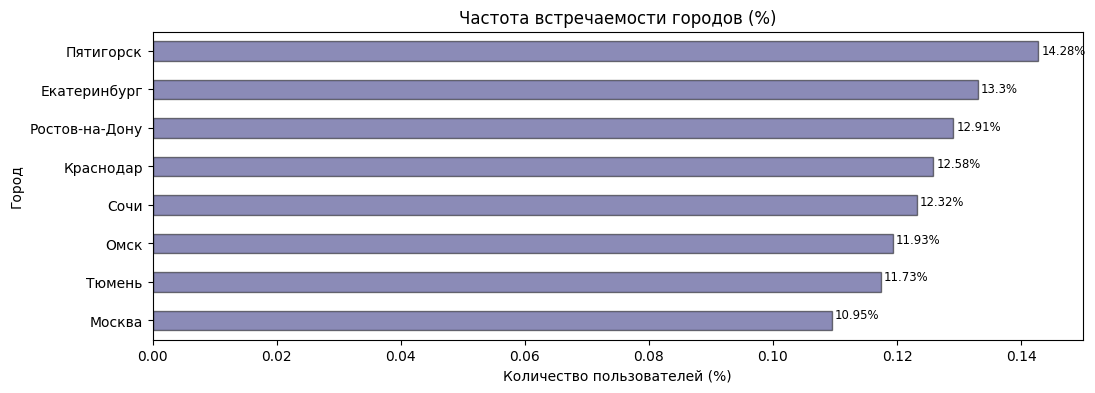

In [64]:
cities = len(users)
cities_freq = users.groupby('city').size()/cities
cities_freq_filtered = cities_freq[cities_freq > 0.015].sort_values()
ax = cities_freq_filtered.plot(kind='barh', color='#191970', alpha=0.5, figsize=(12,4), ec='black')

labels = dict(cities_freq_filtered)
labels

#аннотации в процентах
i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'small')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

plt.title('Частота встречаемости городов (%)')
plt.xlabel('Количество пользователей (%)')
plt.ylabel('Город')
None

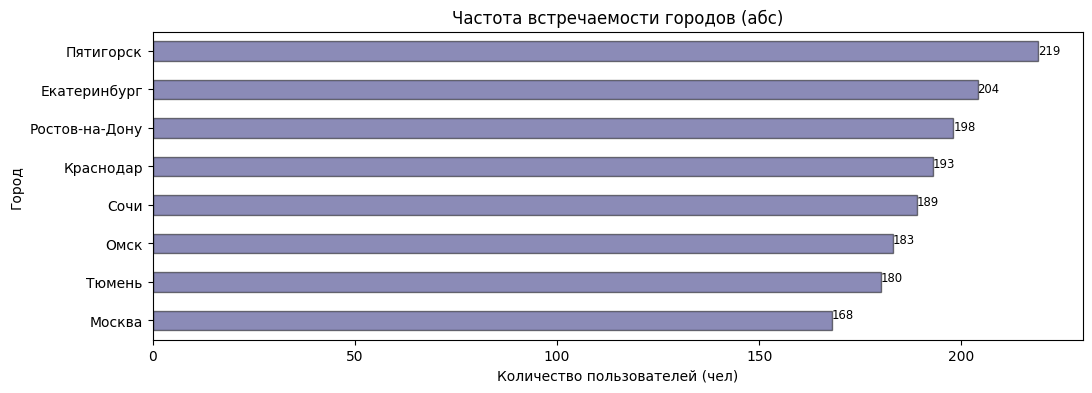

In [65]:
cities = len(users)
cities_freq = users.groupby('city').size()
cities_freq_filtered = cities_freq.sort_values()
ax = cities_freq_filtered.plot(kind='barh', color='#191970', alpha=0.5, figsize=(12,4), ec='black')

labels = dict(cities_freq_filtered)
labels

#аннотации в абсолютных значениях
i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city])), 
            fontsize = 'small')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

plt.title('Частота встречаемости городов (абс)')
plt.xlabel('Количество пользователей (чел)')
plt.ylabel('Город')
None

В датафрейме `users` содержится информация о пользователях из восьми городов: Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва. На графике представлено процентное соотношение пользователей из разных городов.\
Больше всего пользователей из Пятигорска (14.28%, 219 пользователей), меньше всего из Москвы (10.95%, 168 пользователей).

### Соотношение пользователей с подпиской и без подписки

Text(0, 0.5, 'Количество пользователей (чел)')

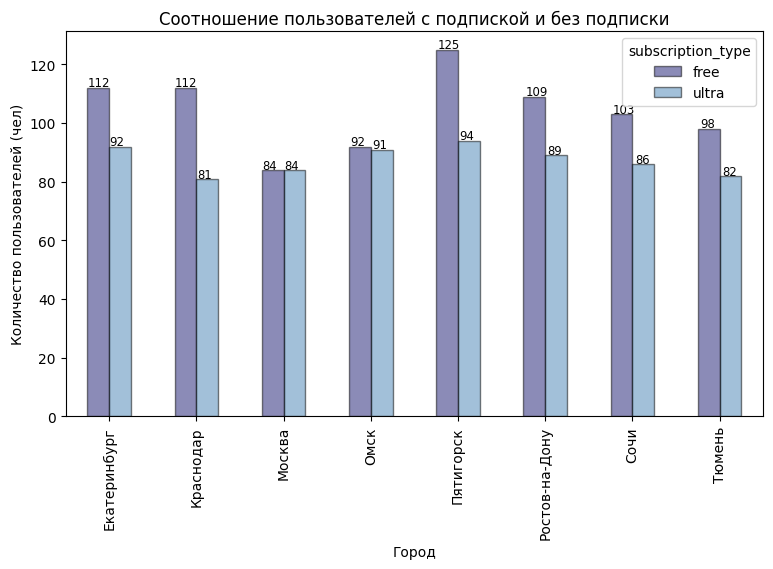

In [66]:
subscription_pivot = users.pivot_table(index='city',columns='subscription_type',values='user_id',aggfunc='count')
ax_sub = subscription_pivot.plot.bar(color=['#191970','#4682B4'], alpha=0.5, figsize=(9,5), ec='black')

for p in ax_sub.patches:
    ax_sub.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize = 'small')

plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Город')
plt.ylabel('Количество пользователей (чел)')

На графике видим распределение пользователей с подпиской и без подписки в восьми городах.\
Так, в Пятигорске, в котором больше всего пользователей, и больше всего пользователей с подпиской, а в Москве количество пользователей с подпиской и без одинаково.

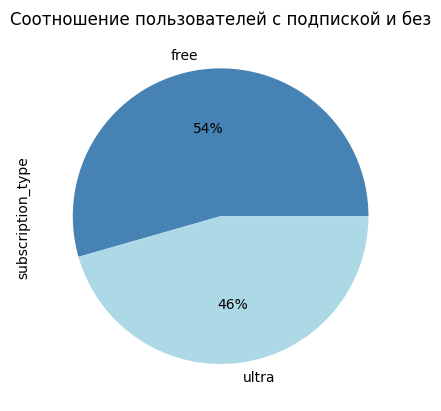

In [67]:
users['subscription_type'].value_counts().plot(kind='pie', colors=['steelblue','lightblue'], title='Соотношение пользователей с подпиской и без', y='points', autopct='%1.0f%%')
None

Круговая диаграмма показывает, что количества пользователей с подпиской и без нее близки, но всё же пользователей без подписки больше: 54% против 46%.

### Возраст пользователей

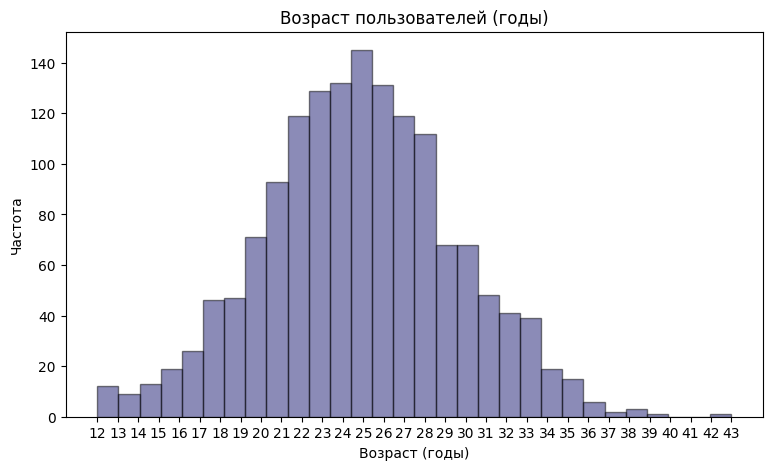

In [68]:
users['age'].plot(kind='hist', ec='black', bins=30, color='#191970', alpha=0.5, figsize=(9,5))
plt.xticks(np.arange(min(users['age']), max(users['age'])+1, 1.0))
plt.title('Возраст пользователей (годы)')
plt.xlabel('Возраст (годы)')
plt.ylabel('Частота')
None

In [69]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

На графике видим, что наша выборка по возрасту подчиняется нормальному распределению. Более всего пользователей в возрасте 25 лет с равномерным снижением количества в обе стороны.\
Средний возраст 24,9, медиана 25 лет.

### Расстояние, которое пользователь преодолел за одну поездку

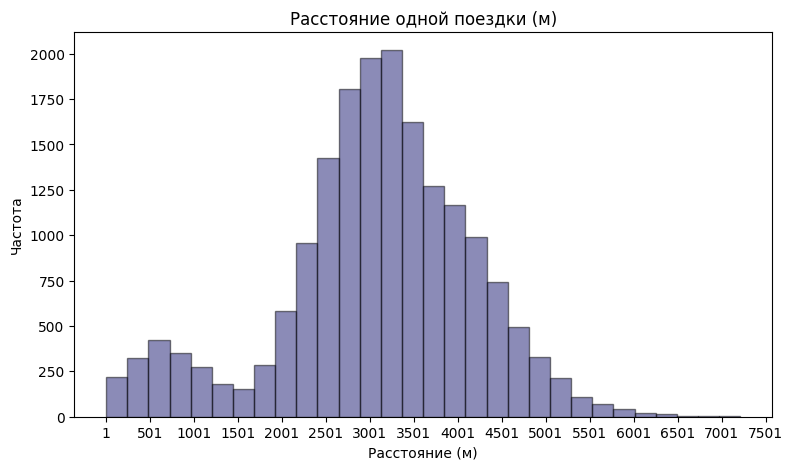

In [70]:
rides['distance'].plot(kind='hist', ec='black', bins=30, color='#191970', alpha=0.5, figsize=(9,5))
plt.xticks(np.arange(min(rides['distance']), max(rides['distance'])+500, 500.0))
plt.title('Расстояние одной поездки (м)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
None

График имеет два возвышения: среди пользователей относительно популярны короткие поездки (500-750 м) и крайне популярны длинные поездки (3000-3500 м).\
При этом в выборке мало поездок с промежуточным расстоянием между наблюдаемыми пиками.\
Короткие — вероятно, пользователи используют самокат как транспорт до другого транспорта (до остановки автобуса или до метро) или просто пробуют покататься. Длинные — поездки непосредственно на самокате до какого-то пункта назначения.

### Продолжительность поездок

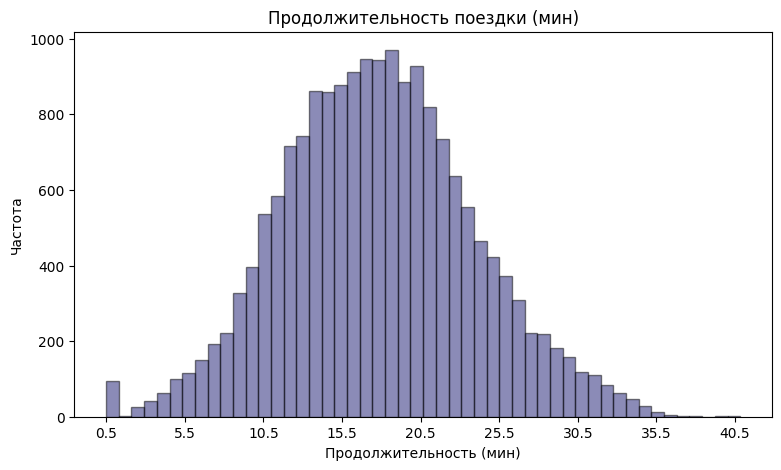

In [71]:
rides['duration'].plot(kind='hist', ec='black', bins=50, color='#191970', alpha=0.5, figsize=(9,5))
plt.xticks(np.arange(min(rides['duration']), max(rides['duration'])+1, 5.0))
plt.title('Продолжительность поездки (мин)')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
None

Судя по графику, продолжительность поездок в нашей выборке также подчиняется нормальному распределению с пиком на 17 минутах и равномерным снижением популярности поездок с большей и меньшей продолжительностью.

In [72]:
rides.query('duration < 1.0')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


В датафрейме с информацией о поездках имеется 95 строк с записями о поездках, продолжительностью менее 90 секунд. При этом, расстояние в этих строках адекватное и похожее на реальную поездку.\
Вероятно, имеет место техническая проблема: по какой-то причине время поездки записано неверно.
В такой ситуации стоит озвучить эту проблему тем, кто предоставил данные для анализа. Использовать эти строки для анализа мы можем, поскольку в них проблема только в продолжительности, остальные столбцы содержат адекватные данные.

## Объединение данных

### Объединение датафреймов

In [73]:
data = users.merge(rides, how = 'left', left_on='user_id', right_on='user_id') #поэтапно смержим датафреймы
data

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [74]:
data = data.merge(subscriptions, how = 'left', left_on='subscription_type', right_on='subscription_type')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Получили датафрейм со всей информацией.

Самый большой датафрейм — rides, в нем 18068 строк. При слиянии с датафреймом users по users_id мы получим датафрейм, содержащий то же количество строк, что и в rides.\
Проверяем — под таблицей указано то же число строк, что и было в изначальном.\
Вторым этапом объединяем результат предыдущего действия с subscriptions по subscription_type, получаем опять же те же 18068 строк.
Датафрейм о пользователях содержал в каждой строке уникальную информацию, а датафрейм о поездках — все поездки вообще за календарный год, в том числе многократные поездки одного пользователя, поэтому мы видим строки с одним и тем же user_id, однако с разными данными относительно поездок. Это не дубликаты.

### Дополнительные датафреймы с информацией о пользователях с подпиской и без неё

In [75]:
data_sub = data.query('subscription_type == "ultra"') #с подпиской
data_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [76]:
data_non_sub = data.query('subscription_type == "free"') #без подписки
data_non_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


### Визуализация данных о расстоянии и времени для пользователей разных категорий

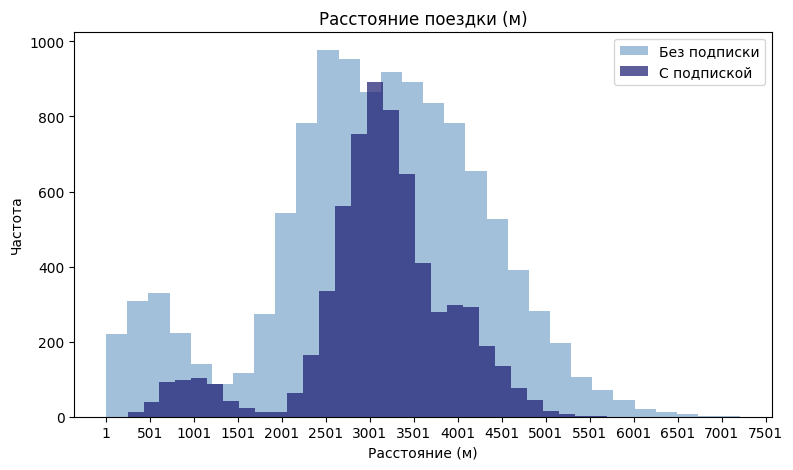

In [77]:
data_non_sub['distance'].plot(kind='hist', bins=30, color='#4682B4', alpha=0.5, figsize=(9,5))
data_sub['distance'].plot(kind='hist', bins=30, color='#191970', alpha=0.7, figsize=(9,5))
plt.xticks(np.arange(min(rides['distance']), max(rides['distance'])+500, 500.0))
plt.legend(['Без подписки', 'С подпиской'])
plt.title('Расстояние поездки (м)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
None

На графике видим, что расстояния поездок пользователей с подпиской и без подписки распределены с одинаковой формой гистограммы с малым пиком в области коротких поездок (около 500 м) и высоким пиком на большей дистанции поездки (2500-3000), однако пользователей без подписки очевидно больше и пики (короткие и длинные поездки) шире.\
Можем сделать вывод, что тактика использования самокатов у пользователей не зависит от наличия подписки.

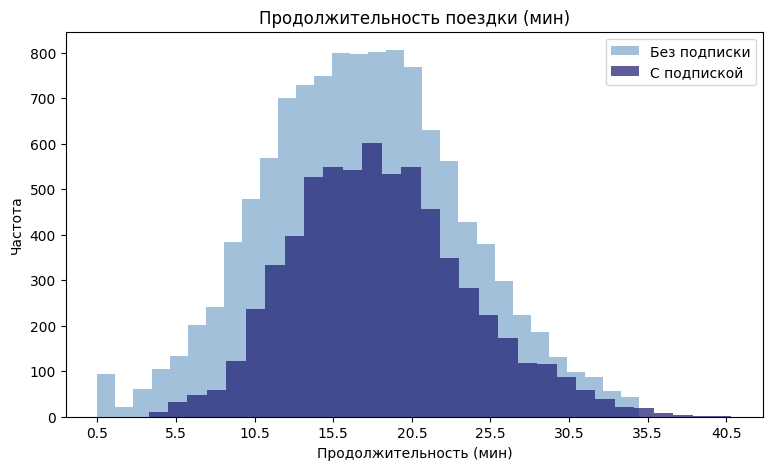

In [78]:
data_non_sub['duration'].plot(kind='hist', bins=30, color='#4682B4', alpha=0.5, figsize=(9,5))
data_sub['duration'].plot(kind='hist', bins=30, color='#191970', alpha=0.7, figsize=(9,5))
plt.xticks(np.arange(min(rides['duration']), max(rides['duration'])+1, 5.0))
plt.legend(['Без подписки', 'С подпиской'])
plt.title('Продолжительность поездки (мин)')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
None

Наблюдаем схожую картину: продолжительность поездок подчиняется нормальному распределению независимо от наличия подписки, при этом поездок без подписки заметно больше, а средняя продолжительность в обоих случаях одинакова и находится в диапазоне 15-20 минут.\
Кроме того, в графике о поездках без подписки отмечаем пик в области ультракоротких поездок: 0,5-1,5 минут. Этот пик можно объяснить вероятной технической ошибкой: выше мы рассмотрели строки с такой продолжительностью поездки, в которых, однако, содержится адекватное расстояние.

## Подсчёт выручки

### Агрегация данных: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [79]:
data['duration'] = np.ceil(data['duration']) #округлим продолжительность до целого

In [80]:
rides_by_month = data.pivot_table(index= ['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
rides_by_month.columns = ['_'.join(col) for col in rides_by_month.columns.values]
rides_by_month = rides_by_month.drop(columns=['count_duration'])
rides_by_month = rides_by_month.reset_index()
rides_by_month

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42.0
1,1,4,1,754.159807,7.0
2,1,8,2,6723.470560,46.0
3,1,10,2,5809.911100,32.0
4,1,11,3,7003.499363,56.0
...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0
11327,1534,8,2,7622.453034,48.0
11328,1534,9,1,4928.173852,23.0
11329,1534,11,4,13350.015305,78.0


Агрегировали информацию: теперь у нас есть суммарные данные (количество (count_distance), расстояние (sum_distance) и длительность поездок (sum_duration) по месяцам для каждого пользователя. 

### Подсчёт помесячной выручки

In [81]:
rides_by_month = rides_by_month.merge(users, how='left', on='user_id')
rides_by_month = rides_by_month.merge(subscriptions, how = 'left', on='subscription_type')
rides_by_month

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,Альберт,25,Краснодар,free,8,50,0
11327,1534,8,2,7622.453034,48.0,Альберт,25,Краснодар,free,8,50,0
11328,1534,9,1,4928.173852,23.0,Альберт,25,Краснодар,free,8,50,0
11329,1534,11,4,13350.015305,78.0,Альберт,25,Краснодар,free,8,50,0


In [93]:
#через функцию и apply()
#def proceed(row):
#  proceed_sum = 0
#  proceed_sum = (row['start_ride_price'] * row['count_distance'] +
#              row['minute_price'] * row['sum_duration'] +
#              row['subscription_fee']
#              )
#  return proceed_sum
#
#rides_by_month['proceed'] = rides_by_month.apply(proceed, axis=1)
#rides_by_month[['user_id', 'name', 'month', 'proceed']]

In [94]:
#через векторные операции
rides_by_month['proceed'] = rides_by_month['start_ride_price'] * rides_by_month['count_distance'] +\
rides_by_month['minute_price'] * rides_by_month['sum_duration'] + rides_by_month['subscription_fee']
rides_by_month[['user_id', 'name', 'month', 'proceed']]

,user_id,name,month,proceed
0,1,Кира,1,451.0
1,1,Кира,4,241.0
2,1,Кира,8,475.0
3,1,Кира,10,391.0
4,1,Кира,11,535.0
...,...,...,...,...
11326,1534,Альберт,6,308.0
11327,1534,Альберт,8,484.0
11328,1534,Альберт,9,234.0
11329,1534,Альберт,11,824.0


Подсчитали помесячную выручку по пользователям.

## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Тратят ли пользователи с подпиской больше времени на поездки?

**Нулевая гипотеза:** средняя продолжительность поездок не зависит от наличия подписки.\
**Альтернативная гипотеза:** пользователи с подпиской тратят больше времени.

In [84]:
alpha = 0.05

results = st.ttest_ind(data_sub['duration'], data_non_sub['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Альтернативная гипотеза верна: средняя продолжительность поездок пользователей с подпиской больше продолжительности поездок пользователей без подписок.\
Проверим.

In [85]:
print('Среднее время поездки пользователей c подпиской:', round(data_sub['duration'].mean(),2))
print('Среднее время поездки пользователей без подписки:', round(data_non_sub['duration'].mean(),2))

Среднее время поездки пользователей c подпиской: 18.54
Среднее время поездки пользователей без подписки: 17.39


### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**Нулевая гипотеза:** среднее расстояние поездки пользователи с подпиской равна 3130 метрам.\
**Альтернативная гипотеза:** среднее расстояние поездки пользователи с подпиской больше 3130 метров.

In [95]:
exp_mean_distance = 3130

alpha = 0.05

results = st.ttest_1samp(data_sub['distance'], exp_mean_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [87]:
print('Среднее дистанция поездки пользователей c подпиской:', round(data_sub['distance'].mean(),0))

Среднее дистанция поездки пользователей c подпиской: 3115.0


Средняя дистанция поездки пользователей с подпиской меньше 3130 метров, мы подтвердили нулевую гипотезу.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Нулевая гипотеза:** помесячная выручка от пользователей с подпиской и без равны.\
**Альтернативная гипотеза:** помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

In [88]:
rides_by_month_ultra = rides_by_month[rides_by_month['subscription_type'] == 'ultra']
rides_by_month_free = rides_by_month[rides_by_month['subscription_type'] == 'free']

alpha = 0.05 

results = st.ttest_ind(rides_by_month_ultra['proceed'], rides_by_month_free['proceed'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Подтвердили альтернативную гипотезу: помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

In [89]:
print('Средняя помесячная выручка от пользователи с подпиской:', round(rides_by_month_ultra['proceed'].mean(),2))
print('Средняя помесячная выручка от пользователи без подписки:', round(rides_by_month_free['proceed'].mean(),2))

Средняя помесячная выручка от пользователи с подпиской: 362.79
Средняя помесячная выручка от пользователи без подписки: 328.64


### Влияет ли обновление серверов на количество обращений?
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

**Ответ:** В данном случае правильнее применить тест проверки гипотез о равенстве средних для зависимых (парных) выборок.\
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel(), передав ему два набора данных: до и после обновления.

## Шаг 7: проверка гипотез

### Гипотеза о рассылке промокодов
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.\
Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 1001 artists>

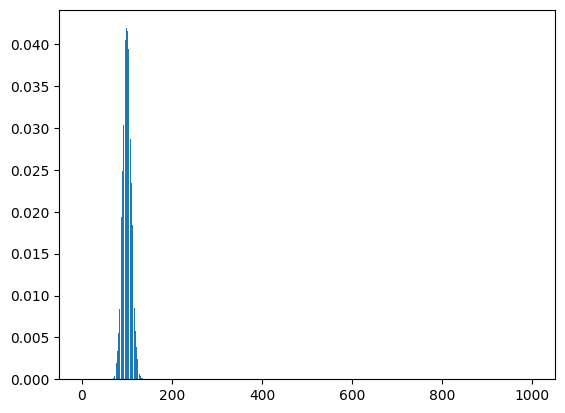

In [90]:
n = 1000
p = 0.1
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)

plt.bar(range(0, n + 1), distr)

In [91]:
for n in range (500,1500):
    if binom.cdf(99, n, p) < 0.05:
        print("Минимальное число промокодов:", n)
        break

Минимальное число промокодов: 1161


Для того, чтобы акция была успешна и после нее было не менее 100 продлений подписки с вероятностью невыполнения плана не более 5% нужно сделать рассылку с как минимум 1161 промокодом.

### Гипотеза о push-уведомлениях
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 
1 млн уведомлений.\
С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [92]:
n = 1000000
p = 0.4

lmbd = n * p
std = sqrt(n * p * (1 - p))
distr = st.norm(lmbd, std)

x = 399500

result = distr.cdf(x)
print('Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей:',
      round(result, 2))

Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15


С вероятностью в 15% при рассылке 1 млн. пуш-уведомлений их откроют не более 399,5 тыс. пользователей.

## Выводы

Для анализа были представлены данные о работе сервиса аренды самокатов в восьми российских городах: Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва.
 - Больше всего пользователей из Пятигорска (14.28%, 219 человек), меньше всего из Москвы (10.95%, 168 человек).
 - 54% пользователей — без подписки. Соответственно, 46% с подпиской.
 - В Пятигорске, в котором больше всего пользователей, и больше всего пользователей с подпиской, а в Москве количество пользователей с подпиской и без одинаково.
 - Средний возраст пользователей 24,9 лет, медиана 25 лет.
 - Среди пользователей относительно популярны короткие поездки (500-750 м) и крайне популярны длинные поездки (3000-3500 м).

В ходе исследования были подтверждены следующие гипотезы:
 - Средняя продолжительность поездок пользователей с подпиской больше продолжительности поездок пользователей без подписок.
 - Средняя дистанция поездки пользователей с подпиской составляет 3115 метров.
 - Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

Также были проведены расчеты для отдела маркетинга:
 - Для того, чтобы акция была успешна и после нее было не менее 100 продлений подписки с вероятностью невыполнения плана не более 5% нужно сделать рассылку с как минимум 1161 промокодом.
 - С вероятностью в 15% при рассылке 1 млн. пуш-уведомлений их откроют не более 399,5 тыс. пользователей.